In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import treecorr
import healpy as hp
import os
import time
from sklearn.preprocessing import MinMaxScaler

start_time = time.time()

import sys
sys.path.append('src')

In [2]:
import fitsio
from astropy.io import fits
from minisom import MiniSom
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.patches import RegularPolygon, Ellipse
from matplotlib import cm, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
GETBACK=sys.path

In [4]:
current_path = os.getcwd()  # Obtiene el directorio actual
parent_path = os.path.dirname(current_path)  # Sube un nivel
os.chdir(parent_path)  # Cambia al directorio padre
sys.path = os.getcwd()

In [5]:
GETBACK2=sys.path

In [6]:
cat = pd.read_parquet("property_maps_desy3.parquet.gzip_rlkey=raykn68b2908fkvhhw9cpz2g8")

In [7]:
os.chdir("Modulos")

In [8]:
MainArray = np.loadtxt("Main_Parmeters.txt")

In [9]:
som_dim = int(MainArray[0])
JoyDiv=int(MainArray[1])
dif=int(MainArray[2])
JD=int(MainArray[3])
SJ=int(MainArray[4])

In [10]:
del MainArray

In [11]:
cat=cat[(cat['FOREGROUND_MASK']==0) & (cat['BADREGIONS_MASK']<=1) & (cat['FRACDET']>0.8)]
catwo=cat.copy(deep=True)
cat=[]
catwo = catwo.drop(['HPIX_4096','FOREGROUND_MASK','BADREGIONS_MASK','EBV_SFD98'], axis=1)

In [12]:
catwo = catwo.iloc[0:0]

In [13]:
def plot_som(ax, som_heatmap, topology='rectangular', colormap=cm.viridis, cbar_name=None,
            vmin=None, vmax=None):
    
    vmin = np.quantile(som_heatmap[~np.isnan(som_heatmap)], 0.01)
    vmax = np.quantile(som_heatmap[~np.isnan(som_heatmap)], 0.99)
    cscale = (som_heatmap - vmin) / (vmax - vmin)
    som_dim = cscale.shape[0]
    
    if topology == 'rectangular':
        ax.matshow(som_heatmap.T, cmap=colormap, vmin=vmin, vmax=vmax)
    else:
        yy, xx = np.meshgrid(np.arange(som_dim), np.arange(som_dim))
        shift = np.zeros(som_dim)
        shift[::2] = -0.5
        xx = xx + shift
        for k in range(cscale.shape[0]):
            for j in range(cscale.shape[1]):
                wy = yy[(k, j)] * np.sqrt(3) / 2
                if np.isnan(cscale[k, j]):
                    color = 'k'
                else:
                    color = colormap(cscale[k, j])
                
                hex = RegularPolygon((xx[(k, j)], wy), 
                                     numVertices=6, 
                                     radius=1 / np.sqrt(3),
                                     facecolor=color, 
                                     edgecolor=color,
                                     lw=0.2)
                ax.add_patch(hex)

    ax.set_aspect('equal')
    
    ax.set_xlim(-1, som_dim - 0.5)
    ax.set_ylim(-0.5, som_dim * np.sqrt(3) / 2)
    
    scmap = plt.scatter([0, 0], [0, 0], s=0, c=[vmin, vmax], cmap=colormap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(scmap, cax=cax)
    cb.ax.tick_params(labelsize=5)
    cb.set_label(cbar_name) 
    ax.axis('off')

In [14]:
SOM = np.loadtxt("Modulo_SOM_RESULTS.txt").reshape(som_dim+dif,som_dim,len(catwo.columns))

In [15]:
sys.path=GETBACK

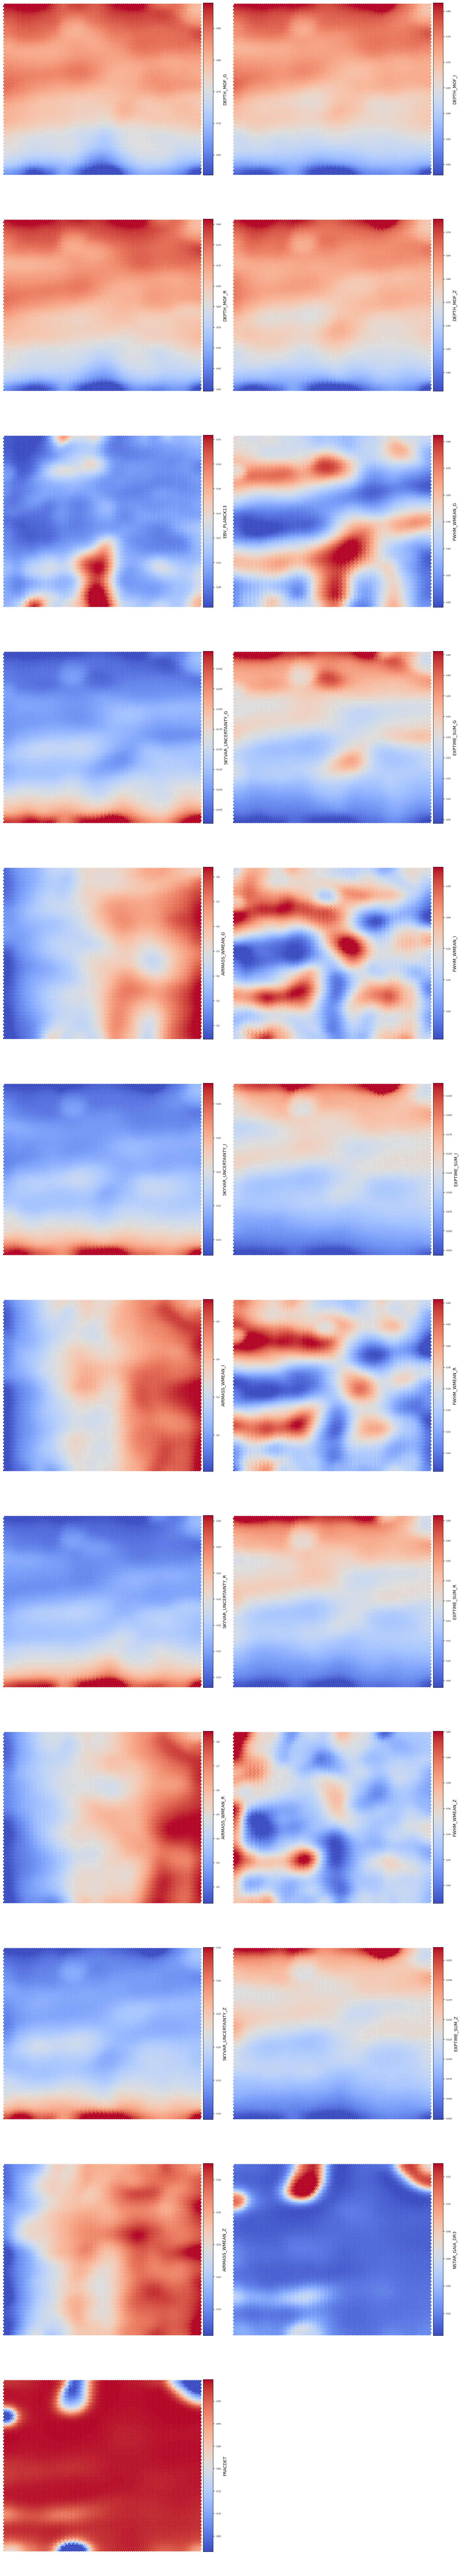

In [16]:
from matplotlib import cm
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

topology = 'hexagonal'

num_plots = len(catwo.columns)
num_rows = (num_plots + 1) // 2 
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 7 * num_rows))

axs = axs.flatten()

for i in range(num_plots):
    ax = axs[i]
    plot_som(ax, SOM[:, :, i], topology=topology, colormap=cm.coolwarm, cbar_name=catwo.columns[i])
    filename = os.path.join("plots",f"plot_som_{catwo.columns[i]}.png")
    fig_individual, ax_individual = plt.subplots(figsize=(8, 6))  # Crear una figura separada 
    plot_som(ax_individual, SOM[:, :, i], topology=topology, colormap=cm.coolwarm, cbar_name=catwo.columns[i])
    fig_individual.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig_individual)
    
if num_plots % 2 != 0:
    axs[-1].axis('off')
plt.tight_layout()
plt.show()